In [1]:
# Let's load our weapons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
import tensorflow_datasets as tfds
import cv2

from functools import partial
import sys


In [2]:
# Let's take flower dataset from datasets ( why flowers dataset only ? becuase its pleasing for eyes to see :)

dataset,info=tfds.load('tf_flowers',as_supervised=True,with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
# Let's get some information about our dataset, info is self explanatory :)

info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [4]:
# what are all the available flowers in the dataset 

class_names=info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [5]:
# How many examples we have in our dataset?

info.splits

 # Oops ! we have only train data, we need to mention while loading to get it separately,lets see how to do that

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [6]:
# we can split while loading the data

test_set_raw,valid_set_raw,train_set_raw=tfds.load('tf_flowers',split=['train[:10%]','train[10%:25%]','train[25%:]'],as_supervised=True)

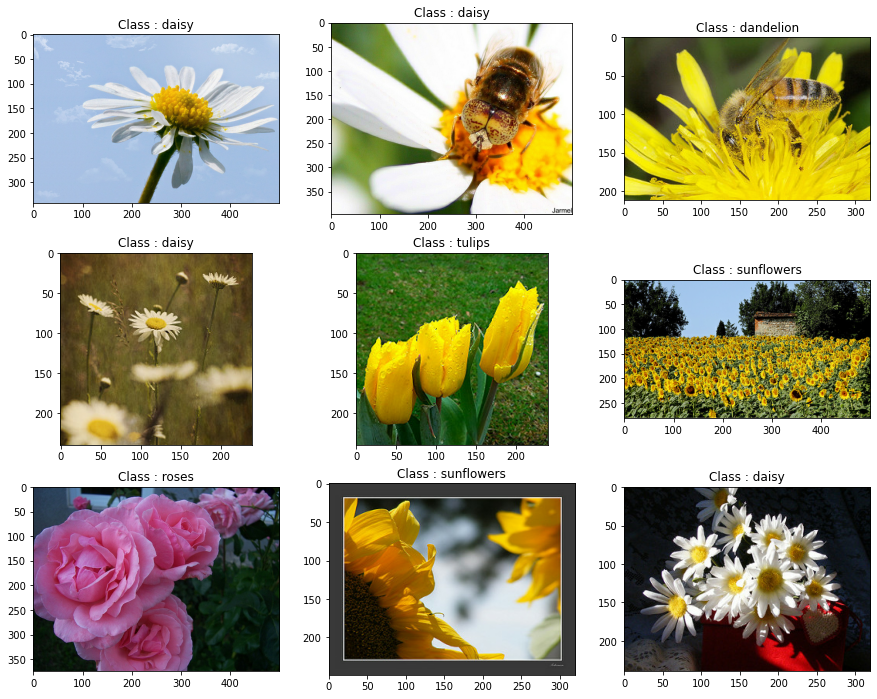

In [7]:
'''
Let's have a look at beautiful flowers

'''


plt.figure(figsize=(15,12))
index=0
for image,label in train_set_raw.shuffle(100).take(9):
  index+=1
  plt.subplot(3,3,index)
  plt.imshow(image)
  plt.title('Class : {0}'.format(class_names[label]))
  
# One thing to notice here, images doesn't have same resolutions

In [8]:
'''
We are doing custom data augmentation, you can use ImageDataGenerator for this if you wish

Note : According to Hands on ML book, its always preferrable to use ImageDataGenerator for small projects, for large projects use custom data augmentation



Central_crop -> used to get center of a image by croping the top,left,right,bottm

random_crop -> as the name suggests we take random crop of image

preprocess  -> we crop the image and resize it to 224x224 and then pass it to preprocess_input() which will make changes to images acc to model


'''

def central_crop(image):
    shape = tf.shape(image)    
    min_dim = tf.reduce_min([shape[0], shape[1]])        
    top_crop = (shape[0] - min_dim) // 4    
    bottom_crop = shape[0] - top_crop    
    left_crop = (shape[1] - min_dim) // 4    
    right_crop = shape[1] - left_crop
    
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)       
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100    
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)        
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    
    resized_image = tf.image.resize(cropped_image, [224, 224])    
    final_image =keras.applications.resnet50.preprocess_input(resized_image * 255)
    return resized_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [13]:
# Let's load our model with weights of imagenet and we dont want top layer to making it as false

# Here i'm using Global Average Pool, which is completely optional to you, you can use any pool layer here 


base_model=keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)

avg=keras.layers.GlobalAveragePooling2D()(base_model.output)

output=keras.layers.Dense(5,activation='softmax')(avg)
model=keras.models.Model(inputs=base_model.input,outputs=output)

94773248/94765736 [==============================] - 2s 0us/step


In [14]:

# Have a look at our layer names

for index,layers in enumerate(base_model.layers):
  print(index,layers.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [15]:
# Let's Freeze base_model layers

for layer in base_model.layers:
  layer.trainable=False

In [18]:

# Let's train our model

model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

resnet= model.fit(train_set,
                  epochs=30,
                  steps_per_epoch=int(0.75 * 3670 / batch_size),
                  validation_data=valid_set,
                  validation_steps=int(0.15 * 3670 / batch_size)
                  )

Epoch 1/30
86/86 [==============================] - 13s 123ms/step - loss: 0.1798 - accuracy: 0.9436 - val_loss: 0.3218 - val_accuracy: 0.8805
Epoch 2/30
86/86 [==============================] - 10s 113ms/step - loss: 0.1471 - accuracy: 0.9504 - val_loss: 0.3265 - val_accuracy: 0.8787
Epoch 3/30
86/86 [==============================] - 10s 117ms/step - loss: 0.1269 - accuracy: 0.9628 - val_loss: 0.3663 - val_accuracy: 0.8750
Epoch 4/30
86/86 [==============================] - 10s 120ms/step - loss: 0.1245 - accuracy: 0.9624 - val_loss: 0.3260 - val_accuracy: 0.8805
Epoch 5/30
86/86 [==============================] - 10s 119ms/step - loss: 0.0924 - accuracy: 0.9779 - val_loss: 0.3303 - val_accuracy: 0.8787
Epoch 6/30
86/86 [==============================] - 10s 115ms/step - loss: 0.1110 - accuracy: 0.9654 - val_loss: 0.3354 - val_accuracy: 0.8879
Epoch 7/30
86/86 [==============================] - 10s 114ms/step - loss: 0.0888 - accuracy: 0.9783 - val_loss: 0.3293 - val_accuracy: 0.8842

In [20]:
train_loss=resnet.history['loss']
cv_loss=resnet.history['val_loss']
train_acc=resnet.history['accuracy']
cv_acc=resnet.history['val_accuracy']

In [21]:
# printing a table depicting the detail about the trained model

log_frame = pd.DataFrame(columns = ["Epoch", "Train_Loss", "Train_Accuracy", "CV_Loss", "CV_Accuracy"])
log_frame["Epoch"] = list(range(1,31))
log_frame["Train_Loss"] = train_loss
log_frame["Train_Accuracy"] = train_acc
log_frame["CV_Loss"] = cv_loss
log_frame["CV_Accuracy"] = cv_acc 
log_frame

,Epoch,Train_Loss,Train_Accuracy,CV_Loss,CV_Accuracy
0,1,0.172448,0.944767,0.321816,0.880515
1,2,0.150022,0.949855,0.326501,0.878676
2,3,0.135938,0.954942,0.366343,0.875000
3,4,0.113830,0.965480,0.325959,0.880515
4,5,0.092151,0.976017,0.330296,0.878676
5,6,0.109425,0.966570,0.335450,0.887868
6,7,0.089685,0.974201,0.329288,0.884191
7,8,0.079346,0.980378,0.321425,0.893382
8,9,0.077419,0.976017,0.337990,0.878676
9,10,0.071258,0.981468,0.362053,0.876838


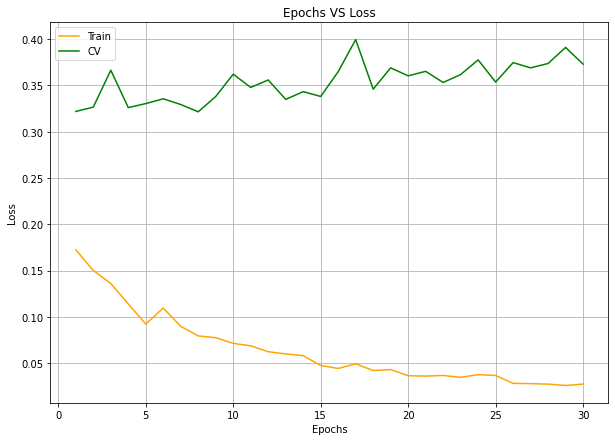

In [22]:
# Plotting Epochs vs Loss

def plotting(epoch,train_los,val_los):
    plt.figure(figsize=(10,7))
    plt.plot(epoch,train_los,color='orange',label='Train')
    plt.plot(epoch,val_los,color='green',label='CV')
    plt.grid()
    plt.title("Epochs VS Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plotting(log_frame['Epoch'],log_frame['Train_Loss'],log_frame['CV_Loss'])

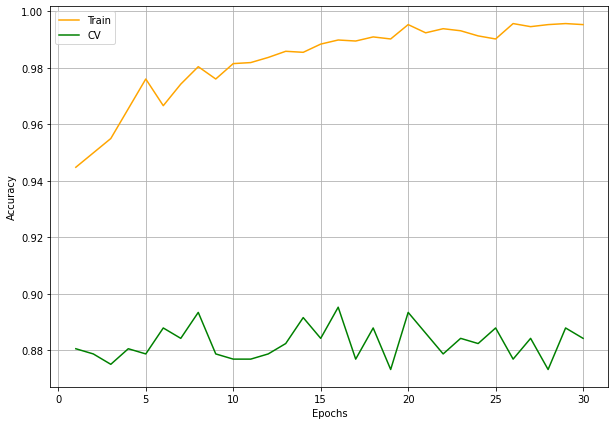

In [23]:
# Plotting Epoch Vs Accuracy

def plot_acc(epoch,train_ac,val_ac):
    plt.figure(figsize=(10,7))
    plt.plot(epoch,train_ac,color='orange',label='Train')
    plt.plot(epoch,val_ac,color='green',label='CV')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    
plot_acc(log_frame['Epoch'],log_frame['Train_Accuracy'],log_frame['CV_Accuracy'])

In [43]:
# If we do better image processing may be we will get better results, based on the above chart we can say that accuracy is saturated 

In [42]:
#  Predicting on the test data 

pred=model.evaluate(test_set)
print(f"Accuracy {pred[1]}")
print(f"Loss {pred[0]}")

Accuracy 0.912806510925293
Loss 0.30077460408210754
